In [1]:
import afqinsight as afq

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPool1D, MaxPooling1D, Dropout
from keras.regularizers import l1_l2, l2
from keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer

In [5]:
pwd

'/Users/ceciliabarnes/Documents/DIRECT/afq-cnn/notebooks'

In [43]:
X, y, groups, feature_names, group_names, subjects, classes = afq.datasets.load_afq_data(
    workdir="../data/raw/cam-can",
    dwi_metrics=["dki_md", "dki_fa"],
    target_cols=["age"],
    index_col="Observations",
    fn_nodes="combined_tract_profiles.csv",
    fn_subjects="participant_data.tsv",
)

In [44]:
X.shape, y.shape

((641, 3600), (641,))

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [78]:
np.count_nonzero(np.isnan(y_test))

1

In [80]:
imp = SimpleImputer(strategy='median')
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)
#y_imp = SimpleImputer(strategy='median')
#y_imp.fit(y_train)
#y_train = imp.transform(y_train)
#y_test = imp.transform(y_test)

In [66]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((480, 3600), (480,), (161, 3600), (161,))

In [67]:
X_train_reshaped = np.swapaxes(X_train.reshape((480, 36, 100)), 1, 2)
X_test_reshaped = np.swapaxes(X_test.reshape((161, 36, 100)), 1, 2)

In [68]:
X_train.shape, X_test.shape

((480, 3600), (161, 3600))

In [69]:
model = Sequential()

# input: 3+D tensor with shape: batch_shape + (steps, input_dim)
# output: 3+D tensor with shape: batch_shape + (new_steps, filters) steps value might have changed due to padding or strides.
model = Sequential()
model.add(Dense(128, activation='relu', 
                input_shape=X_train_reshaped.shape[1:],
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=l2(1e-4),
                activity_regularizer=l2(1e-5)))
model.add(Conv1D(24, kernel_size=2, activation='relu'))
model.add(MaxPool1D(pool_size=2,padding='same'))
model.add(Conv1D(32, kernel_size=2, activation='relu'))
model.add(MaxPool1D(pool_size=2,padding='same'))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPool1D(pool_size=2,padding='same'))
model.add(Conv1D(128, kernel_size=4, activation='relu'))
model.add(MaxPool1D(pool_size=2,padding='same'))
model.add(Conv1D(256, kernel_size=4, activation='relu'))
model.add(MaxPool1D(pool_size=2,padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu',
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=l2(1e-4),
                activity_regularizer=l2(1e-5)))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu',
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=l2(1e-4),
                activity_regularizer=l2(1e-5)))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])

In [70]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 100, 128)          4736      
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 99, 24)            6168      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 50, 24)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 49, 32)            1568      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 25, 32)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 23, 64)            6208      
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 12, 64)          

In [71]:
callback = EarlyStopping(monitor='loss', patience=10)
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=100, validation_data=(X_test_reshaped, y_test), callbacks=callback)
loss_and_metrics = model.evaluate(X_test_reshaped, y_test, batch_size=100)
for name, metric in zip(model.metrics_names, loss_and_metrics):
    print(name, ":", metric)

Epoch 1/100
5/5 [==============================] - 1s 106ms/step - loss: 3198.9117 - mean_squared_error: 3198.8454 - val_loss: nan - val_mean_squared_error: nan
Epoch 2/100
5/5 [==============================] - 0s 47ms/step - loss: 2824.2993 - mean_squared_error: 2824.2324 - val_loss: nan - val_mean_squared_error: nan
Epoch 3/100
5/5 [==============================] - 0s 46ms/step - loss: 884.9366 - mean_squared_error: 884.8120 - val_loss: nan - val_mean_squared_error: nan
Epoch 4/100
5/5 [==============================] - 0s 45ms/step - loss: 607.5257 - mean_squared_error: 607.3588 - val_loss: nan - val_mean_squared_error: nan
Epoch 5/100
5/5 [==============================] - 0s 44ms/step - loss: 738.6654 - mean_squared_error: 738.5685 - val_loss: nan - val_mean_squared_error: nan
Epoch 6/100
5/5 [==============================] - 0s 46ms/step - loss: 497.1970 - mean_squared_error: 497.0730 - val_loss: nan - val_mean_squared_error: nan
Epoch 7/100
5/5 [==============================

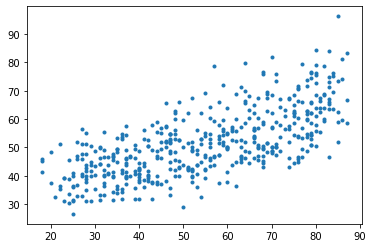

In [72]:
y_hat = model.predict(X_train_reshaped)
plt.plot(y_train, y_hat, linestyle="", marker=".")

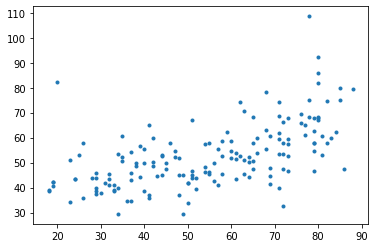

In [73]:
y_hat = model.predict(X_test_reshaped)
plt.plot(y_test, y_hat, linestyle="", marker=".")

In [81]:
r2_score(y_test, y_hat)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').